In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.linalg import eigh
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import mahalanobis
from sklearn.model_selection import train_test_split

# 1. Generate simulated data (Set 1)
def generate_dataset1(n_samples=200):
    c1_mode1 = np.column_stack([np.random.normal(7, 0.9, n_samples),
                               np.random.normal(4.1, 0.8, n_samples)])
    c1_mode2 = np.column_stack([np.random.normal(-8.4, 0.9, n_samples),
                               np.random.normal(-3, 0.7, n_samples)])
    c1 = np.vstack([c1_mode1, c1_mode2])
    
    c2_mode1 = np.column_stack([np.random.normal(5, 0.9, n_samples),
                               np.random.normal(0.1, 1, n_samples)])
    c2_mode2 = np.column_stack([np.random.normal(-4, 0.9, n_samples),
                               np.random.normal(0.1, 0.6, n_samples)])
    c2 = np.vstack([c2_mode1, c2_mode2])
    
    c3_mode1 = np.column_stack([np.random.normal(2.9, 0.9, n_samples),
                               np.random.normal(2.9, 0.5, n_samples)])
    c3_mode2 = np.column_stack([np.random.normal(-4.2, 0.9, n_samples),
                               np.random.normal(-4.2, 0.4, n_samples)])
    c3 = np.vstack([c3_mode1, c3_mode2])
    
    X = np.vstack([c1, c2, c3])
    y = np.hstack([np.zeros(2*n_samples), np.ones(2*n_samples), 2*np.ones(2*n_samples)])
    return X, y

# 2. LLDA implementation (using GMM soft clustering)
class LLDA_GMM:
    def __init__(self, n_components=3, trans_dim =2, alpha=0.1, max_iter=100):
        self.n_components = n_components  # Number of GMM clusters
        self.trans_dim = trans_dim
        self.alpha = alpha
        self.max_iter = max_iter
        
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.n_classes = len(self.classes_)
        
        # Step 1: Soft clustering using GMM
        self.gmm = GaussianMixture(n_components=self.n_components, 
                                  covariance_type='diag')
        self.gmm.fit(X)
        self.mu_k = self.gmm.means_ 
        
        # Step 2: Calculate the posterior probability P(k|x)
        self.P = self.gmm.predict_proba(X)  # (n_samples, n_components)
        
        # Step 3: Initialize the local transformation matrix U_k (d*n vector)
        self.U = [np.random.randn(self.trans_dim, X.shape[1]) for _ in range(self.n_components)]
        for k in range(self.n_components):
            self.U[k] /= np.linalg.norm(self.U[k], axis=0)
            
        # Step 4: Gradient descent optimization objective function J2
        learning_rate = 0.01
        grads = [np.zeros_like(u) for u in self.U]
        
        B_k = [np.zeros((X.shape[1], X.shape[1])) for _ in range(self.n_components)]
        W_k = [np.zeros((X.shape[1], X.shape[1])) for _ in range(self.n_components)]
        B_ij = np.zeros((self.n_components, self.n_components, X.shape[1], X.shape[1]))
        W_ij = np.zeros((self.n_components, self.n_components, X.shape[1], X.shape[1]))
        
        for c in range(self.n_classes):
            X_c = X[y == self.classes_[c]]
            P_c = self.P[y == self.classes_[c]]
            M_c = len(X_c)
            
            for k in range(self.n_components):
                m_ck = (P_c[:, k].reshape(-1,1) * (X_c - self.mu_k[k])).sum(axis=0) / P_c[:, k].sum()
                B_k[k] += M_c * np.outer(m_ck, m_ck)
                
                diff = P_c[:, k].reshape(-1,1)*(X_c - self.mu_k[k]) - m_ck
                W_k[k] += diff.T @ diff
                
                for j in range(k+1, self.n_components):
                    m_cj = (P_c[:, j].reshape(-1,1) * (X_c - self.mu_k[j])).sum(axis=0) / P_c[:, j].sum()
                    B_ij[k,j] += M_c * np.outer(m_ck, m_cj)
                    
                    diff_i = P_c[:, k].reshape(-1,1)*(X_c - self.mu_k[k]) - m_ck
                    diff_j = P_c[:, j].reshape(-1,1)*(X_c - self.mu_k[j]) - m_cj
                    W_ij[k,j] += diff_i.T @ diff_j
            
        # Computing Gradients
        for n in range(X.shape[1]):
            for k in range(self.n_components):
                for _ in range(self.max_iter):
                    grad = 2*(1-self.alpha)*B_k[k] @ self.U[k][:,n] - 2*self.alpha*W_k[k] @ self.U[k][:,n]
                    for j in range(self.n_components):
                        if j != k:
                            grad += 2*(1-self.alpha)*B_ij[min(k,j), max(k,j)] @ self.U[j][:,n]
                            grad -= 2*self.alpha*W_ij[min(k,j), max(k,j)] @ self.U[j][:,n]
                    grads[k][:,n] = grad

                    self.U[k][:,n] -= learning_rate * grads[k][:,n]
                    for i in range(n-1):
                        self.U[k][:,n] -= (self.U[k][:,n].T @ self.U[k][:,i]) * self.U[k][:,i]
                        
                    self.U[k][:,n] /= np.linalg.norm(self.U[k][:,n], axis=0)
                
        print(self.U)
        return self
    
    def transform(self, X):
        # Calculate the posterior probability
        P_test = self.gmm.predict_proba(X)
        
        # Applying local transformations
        y_proj = np.zeros((X.shape[0], self.trans_dim))
        for k in range(self.n_components):
            y_proj += P_test[:, k].reshape(-1,1) * (X - self.mu_k[k]) @ self.U[k].T
        return y_proj

# 3. LLDA_KMeans implementation (hard clustering using KMeans)
class LLDA_KMeans:
    def __init__(self, n_clusters=2, d_components=1, max_iter=100):
        self.n_clusters = n_clusters
        self.d_components = d_components
        self.max_iter = max_iter

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.n_classes = len(self.classes_)
        n_features = X.shape[1]

        # Step 1: KMeans
        self.kmeans = KMeans(n_clusters=self.n_clusters, n_init=10)
        self.kmeans.fit(X)
        self.labels_ = self.kmeans.labels_
        self.mu_k = self.kmeans.cluster_centers_

        # Step 2: Initialize the transformation matrix U_k and orthogonalize it
        self.U = [np.random.randn(n_features, self.d_components) for _ in range(self.n_clusters)]
        for k in range(self.n_clusters):
            q, _ = np.linalg.qr(self.U[k])
            self.U[k] = q

        # Step 3: Gradient Descent Optimization
        learning_rate = 0.01
        for _ in range(self.max_iter):
            B_k = [np.zeros((n_features, n_features)) for _ in range(self.n_clusters)]
            B_ij = np.zeros((self.n_clusters, self.n_clusters, n_features, n_features))
            W_k = [np.zeros((n_features, n_features)) for _ in range(self.n_clusters)]
            W_ij = np.zeros((self.n_clusters, self.n_clusters, n_features, n_features))

            for c in range(self.n_classes):
                X_c = X[y == self.classes_[c]]
                M_c = X_c.shape[0]
                labels_c = self.kmeans.predict(X_c)

                for k in range(self.n_clusters):
                    mask = (labels_c == k)
                    if np.sum(mask) == 0:
                        continue  
                    m_ck = (X_c[mask] - self.mu_k[k]).mean(axis=0)
                    B_k[k] += M_c * np.outer(m_ck, m_ck)

                    diff = (X_c[mask] - self.mu_k[k]) - m_ck
                    W_k[k] += diff.T @ diff

                    for j in range(self.n_clusters):
                        if j == k:
                            continue
                        mask_j = (labels_c == j)
                        if np.sum(mask_j) == 0:
                            continue
                        m_cj = (X_c[mask_j] - self.mu_k[j]).mean(axis=0)
                        B_ij[k, j] += M_c * np.outer(m_ck, m_cj)

            B_tilde = np.zeros((self.d_components, self.d_components))
            W_tilde = np.zeros((self.d_components, self.d_components))
            for k in range(self.n_clusters):
                B_tilde += self.U[k].T @ B_k[k] @ self.U[k]
                W_tilde += self.U[k].T @ W_k[k] @ self.U[k]

            B_tilde_inv = np.linalg.pinv(B_tilde + 1e-6 * np.eye(self.d_components))
            W_tilde_inv = np.linalg.pinv(W_tilde + 1e-6 * np.eye(self.d_components))

            # Gradient Update
            for k in range(self.n_clusters):
                grad = np.zeros((n_features, self.d_components))
                for n in range(self.d_components):
                    u_kn = self.U[k][:, n]
                    term1 = (
                        2 * (self.U[k] @ B_tilde_inv @ (self.U[k].T @ B_k[k])) 
                        - 2 * (self.U[k] @ W_tilde_inv @ (self.U[k].T @ W_k[k]))
                    ) @ u_kn
                    grad[:, n] = term1

                self.U[k] += learning_rate * grad
                q, _ = np.linalg.qr(self.U[k])
                self.U[k] = q

        return self

    def transform(self, X):
        labels_test = self.kmeans.predict(X)
        y_proj = np.zeros((X.shape[0], self.d_components))
        for k in range(self.n_clusters):
            mask = (labels_test == k)
            if np.sum(mask) > 0:
                y_proj[mask] = (X[mask] - self.mu_k[k]) @ self.U[k]
        return y_proj

def calculate_class_errors(y_true, y_pred, classes):
        """
        Count the number of misclassifications for each category.
        """
        class_errors = {}
        for cls in classes:
            # Get the sample index of the current category
            cls_indices = y_true == cls
            # Count the number of errors in the current category
            error_count = np.sum(y_true[cls_indices] != y_pred[cls_indices])
            class_errors[cls] = error_count
        return class_errors

# Evaluation with Euclidean distance
def evaluate_model_Euclidean(X_train, y_train, X_test, y_test):
    classes = np.unique(y_train)
    results = {}
    centroids = []
    for c in np.unique(y_train):
        centroids.append(X_train[y_train==c].mean(axis=0))
    centroids = np.array(centroids)
    y_pred = np.argmin(np.linalg.norm(X_test[:, None] - centroids, axis=2), axis=1)
    class_errors = calculate_class_errors(y_test, y_pred, classes)
    error_counts = list(class_errors.values())
    results['method'] = {
        'error_counts': class_errors,
        'mean_error': np.mean(error_counts),
        'standard_error': np.std(error_counts, ddof=1)
        }
    return results

# Evaluation function using normalized correlation
def evaluate_model_normalized_correlation(X_train, y_train, X_test, y_test):
    classes = np.unique(y_train)
    results = {}
    templates = []
    for c in classes:
        templates.append(X_train[y_train == c].mean(axis=0))
    templates = np.array(templates)

    correlations = []
    for test_sample in X_test:
        sample_correlations = []
        for template in templates:
            correlation = np.corrcoef(test_sample, template)[0, 1]
            sample_correlations.append(correlation)
        correlations.append(sample_correlations)
    correlations = np.array(correlations)

    y_pred = np.argmax(correlations, axis=1)
    class_errors = calculate_class_errors(y_test, y_pred, classes)
    error_counts = list(class_errors.values())
    results['method'] = {
        'error_counts': class_errors,
        'mean_error': np.mean(error_counts),
        'standard_error': np.std(error_counts, ddof=1)
    }
    return results

# Evaluation function using Mahalanobis distance
def evaluate_model_mahalanobis(X_train, y_train, X_test, y_test):
    classes = np.unique(y_train)
    results = {}
    centroids = []
    covariances = []
    for c in classes:
        class_data = X_train[y_train == c]
        centroids.append(class_data.mean(axis=0))
        covariances.append(np.cov(class_data, rowvar=False))
    centroids = np.array(centroids)

    distances = []
    for test_sample in X_test:
        sample_distances = []
        for i, centroid in enumerate(centroids):
            cov_inv = np.linalg.pinv(covariances[i])
            distance = mahalanobis(test_sample, centroid, cov_inv)
            sample_distances.append(distance)
        distances.append(sample_distances)
    distances = np.array(distances)

    y_pred = np.argmin(distances, axis=1)
    class_errors = calculate_class_errors(y_test, y_pred, classes)
    error_counts = list(class_errors.values())
    results['method'] = {
        'error_counts': class_errors,
        'mean_error': np.mean(error_counts),
        'standard_error': np.std(error_counts, ddof=1)
    }
    return results

In [ ]:
results_llda_list = []
result_llda_kmeans_list = []
results_lda_list = []
results_lda_mixture_list = []
results_llda_list_2 = []
result_llda_kmeans_list_2 = []
results_lda_list_2 = []
results_lda_mixture_list_2 = []
results_llda_list_3 = []
result_llda_kmeans_list_3 = []
results_lda_list_3 = []
results_lda_mixture_list_3 = []
for i in range(50):
    # Generate data
    X_train, y_train = generate_dataset1(n_samples=200)
    X_test, y_test = generate_dataset1(n_samples=200)

    # Training LLDA_GMM model
    llda = LLDA_GMM(n_components=3, trans_dim =2, alpha=1, max_iter=50)
    llda.fit(X_train, y_train)
    X_train_llda = llda.transform(X_train)
    X_test_llda = llda.transform(X_test)

    # Training the LLDA_kmeans model
    llda_kmeans = LLDA_KMeans(n_clusters=3, d_components=2)
    llda_kmeans.fit(X_train, y_train)
    X_train_llda_kmeans = llda_kmeans.transform(X_train)
    X_test_llda_kmeans = llda_kmeans.transform(X_test)

    # Training the LDA model
    lda = LinearDiscriminantAnalysis()
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    # Training the LDA mixture model
    lda_mixture = GaussianMixture(n_components=2)
    lda_mixture.fit(X_train)
    X_train_lda_mixture = lda_mixture.predict_proba(X_train)[:, :2]
    X_test_lda_mixture = lda_mixture.predict_proba(X_test)[:, :2]
    means = lda_mixture.means_
    weights = lda_mixture.weights_
    covariances = lda_mixture.covariances_
    eigenvectors_list = []
    eigenvalues_list = []
    for i, cov in enumerate(covariances):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        eigenvectors_list.append(eigenvectors)
        eigenvalues_list.append(eigenvalues)
        print(f"The eigenvectors of {i + 1}-th Gaussian mixture:")
        print(eigenvectors)

    results_llda = evaluate_model_Euclidean(X_train_llda, y_train, X_test_llda, y_test)
    results_llda_list.append(results_llda['method']['mean_error'])

    results_llda_kmeans = evaluate_model_Euclidean(X_train_llda_kmeans, y_train, X_test_llda_kmeans, y_test)
    result_llda_kmeans_list.append(results_llda_kmeans['method']['mean_error'])

    results_lda = evaluate_model_Euclidean(X_train_lda,y_train, X_test_lda, y_test)
    results_lda_list.append(results_lda['method']['mean_error'])

    results_lda_mixture = evaluate_model_Euclidean(X_train_lda_mixture, y_train, X_test_lda_mixture, y_test)
    results_lda_mixture_list.append(results_lda_mixture['method']['mean_error'])

    results_llda = evaluate_model_normalized_correlation(X_train_llda, y_train, X_test_llda, y_test)
    results_llda_list_2.append(results_llda['method']['mean_error'])

    results_llda_kmeans = evaluate_model_normalized_correlation(X_train_llda_kmeans, y_train, X_test_llda_kmeans, y_test)
    result_llda_kmeans_list_2.append(results_llda_kmeans['method']['mean_error'])

    results_lda = evaluate_model_normalized_correlation(X_train_lda,y_train, X_test_lda, y_test)
    results_lda_list_2.append(results_lda['method']['mean_error'])

    results_lda_mixture = evaluate_model_normalized_correlation(X_train_lda_mixture, y_train, X_test_lda_mixture, y_test)
    results_lda_mixture_list_2.append(results_lda_mixture['method']['mean_error'])

    results_llda = evaluate_model_mahalanobis(X_train_llda, y_train, X_test_llda, y_test)
    results_llda_list_3.append(results_llda['method']['mean_error'])

    results_llda_kmeans = evaluate_model_mahalanobis(X_train_llda_kmeans, y_train, X_test_llda_kmeans, y_test)
    result_llda_kmeans_list_3.append(results_llda_kmeans['method']['mean_error'])

    results_lda = evaluate_model_mahalanobis(X_train_lda,y_train, X_test_lda, y_test)
    results_lda_list_3.append(results_lda['method']['mean_error'])

    results_lda_mixture = evaluate_model_mahalanobis(X_train_lda_mixture, y_train, X_test_lda_mixture, y_test)
    results_lda_mixture_list_3.append(results_lda_mixture['method']['mean_error'])

# 1
print("\n Using Euclidean distance:")

average_misclassification = np.mean(np.array(results_llda_list))
std_misclassification = np.std(np.array(results_llda_list))

print("\nThe result for llda_GMM:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(result_llda_kmeans_list))
std_misclassification = np.std(np.array(result_llda_kmeans_list))

print("\nThe result for llda_Kmeans:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_list))
std_misclassification = np.std(np.array(results_lda_list))

print("\nThe result for lda:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_mixture_list))
std_misclassification = np.std(np.array(results_lda_mixture_list))

print("\nThe result for lda mixture:")
print("The average number of misclassification is:", average_misclassification)

# 2
print("\n Using normalized correlation:")

average_misclassification = np.mean(np.array(results_llda_list_2))
std_misclassification = np.std(np.array(results_llda_list_2))

print("\nThe result for llda_GMM:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(result_llda_kmeans_list_2))
std_misclassification = np.std(np.array(result_llda_kmeans_list_2))

print("\nThe result for llda_Kmeans:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_list_2))
std_misclassification = np.std(np.array(results_lda_list_2))

print("\nThe result for lda:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_mixture_list_2))
std_misclassification = np.std(np.array(results_lda_mixture_list_2))

print("\nThe result for lda mixture:")
print("The average number of misclassification is:", average_misclassification)

# 3
print("\n Using Mahalanobis distance:")

average_misclassification = np.mean(np.array(results_llda_list_3))
std_misclassification = np.std(np.array(results_llda_list_3))

print("\nThe result for llda_GMM:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(result_llda_kmeans_list_3))
std_misclassification = np.std(np.array(result_llda_kmeans_list_3))

print("\nThe result for llda_Kmeans:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_list_3))
std_misclassification = np.std(np.array(results_lda_list_3))

print("\nThe result for lda:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_mixture_list_3))
std_misclassification = np.std(np.array(results_lda_mixture_list_3))

print("\nThe result for lda mixture:")
print("The average number of misclassification is:", average_misclassification)

[array([[-0.68651303, -0.86043634],
       [ 0.7271175 , -0.50955795]]), array([[0.98086037, 0.83267413],
       [0.19471242, 0.55376329]]), array([[-0.94539748, -0.74158036],
       [-0.32591962, -0.67086405]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.66175793 -0.74971758]
 [-0.74971758 -0.66175793]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.49596566 -0.86834214]
 [-0.86834214 -0.49596566]]
[array([[-0.57386452, -0.62297604],
       [-0.81895025, -0.78224092]]), array([[0.54334902, 0.80479416],
       [0.83950691, 0.59355401]]), array([[ 0.61186659, -0.91772339],
       [ 0.79096098, -0.39722007]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.49912916 -0.8665276 ]
 [-0.8665276  -0.49912916]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.68426242 -0.72923586]
 [-0.72923586 -0.68426242]]
[array([[ 0.76496727, -0.80051769],
       [ 0.64406915, -0.59930912]]), array([[-0.91319572,  0.89900037],
       [-0.40752126,  0.43794787]]), array([[ 0.94088428, -0.94233017],
  

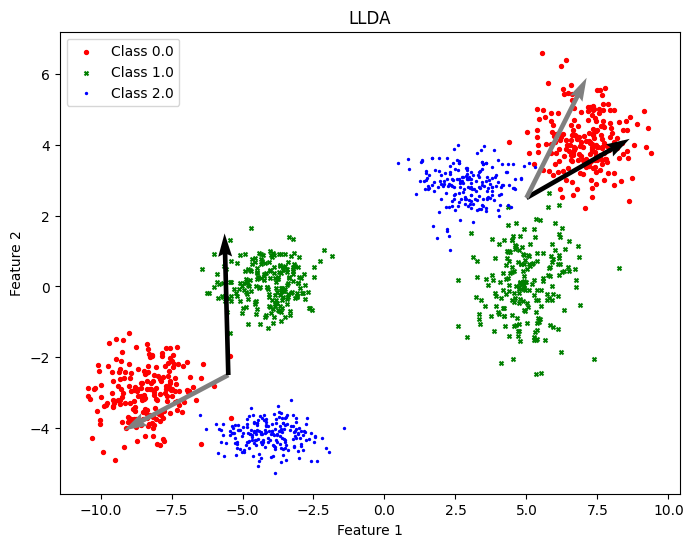

In [ ]:
# plot
colors = ['r', 'g', 'b']
markers = ['o', 'x', '.']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train[y_train == label, 0], X_train[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)

plt.quiver(-5.5, -2.5, -0.92040231, -0.39097262, angles='xy', scale_units='xy', scale=0.25, linestyle='--',color='grey')
plt.quiver(-5.5, -2.5, -0.03295883, 0.99945671, angles='xy', scale_units='xy', scale=0.25, color='black')
plt.quiver(5, 2.5, 0.9089974,  0.41680179, angles='xy', scale_units='xy', scale=0.25, color='black')
plt.quiver(5, 2.5, 0.5299724, 0.84801489, angles='xy', scale_units='xy', scale=0.25,linestyle='--', color='grey')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('LLDA')
plt.legend()
plt.show()

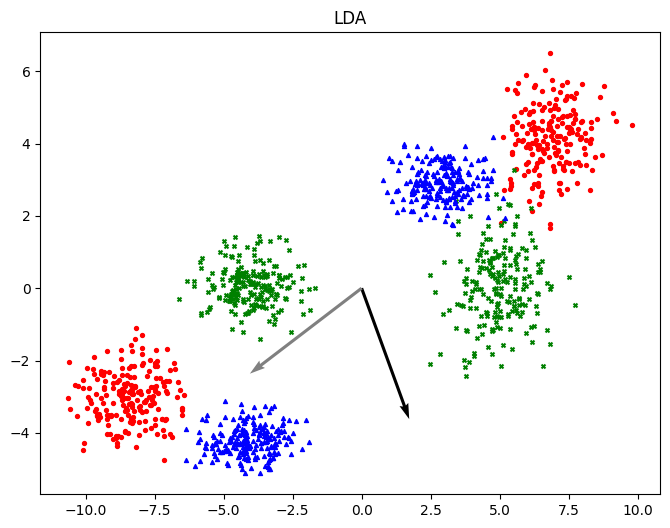

In [ ]:
# Perform LDA
# plot the result
colors = ['r', 'g', 'b']
markers = ['o', 'x', '^']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train[y_train == label, 0], X_train[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)
# obtain the eigenvectors
eigenvectors = lda.scalings_
# plot the first component
origin_x = 0  
origin_y = 0  
origin = np.array([[origin_x, origin_y]]) 
first_component = -eigenvectors[:, 0].reshape(1, -1)
plt.quiver(*origin[:, 0], *origin[:, 1], *first_component[:, 0], *first_component[:, 1], 
           angles='xy', scale_units='xy', scale=0.15, color='black', width=0.005,  label='First Major Component')
# plot the second component
second_component = -eigenvectors[:, 1].reshape(1, -1)
plt.quiver(*origin[:, 0], *origin[:, 1], *second_component[:, 0], *second_component[:, 1],  
           angles='xy', scale_units='xy', scale=0.035, color='gray', width=0.005,  linestyle='--',  linewidth=2, label='Second Component')
plt.title("LDA")
# plt.legend()
plt.show()

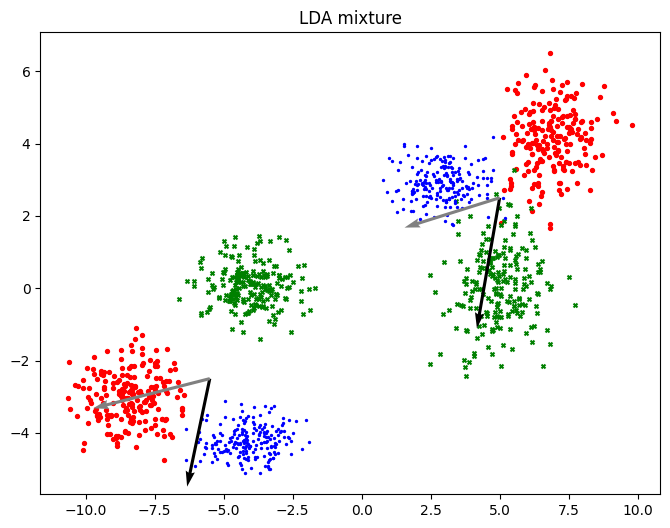

In [36]:
# plot
colors = ['r', 'g', 'b']
markers = ['o', 'x', '.']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train[y_train == label, 0], X_train[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)

from sklearn.linear_model import LinearRegression
# plot the first component
origin_x = -5.5
origin_y = -2.5
origin = np.array([[origin_x, origin_y]]) 
first_component = -covariances[0][:, 1].reshape(1,-1)
plt.quiver(*origin[:, 0], *origin[:, 1], *first_component[:, 0], *first_component[:, 1], 
           angles='xy', scale_units='xy', scale=1.2, color='black', width=0.005,  label='First Major Component')
# plot the second component
second_component = -covariances[0][:, 0].reshape(1,-1)
plt.quiver(*origin[:, 0], *origin[:, 1], *second_component[:, 0], *second_component[:, 1],  
           angles='xy', scale_units='xy', scale=1.2, color='gray', width=0.005,  linestyle='--',  linewidth=2, label='Second Component')
# plot the first component
origin_x = 5
origin_y = 2.5
origin = np.array([[origin_x, origin_y]]) 
first_component = -covariances[1][:, 1].reshape(1,-1)
plt.quiver(*origin[:, 0], *origin[:, 1], *first_component[:, 0], *first_component[:, 1], 
           angles='xy', scale_units='xy', scale=1, color='black', width=0.005,  label='First Major Component')
# plot the second component
second_component = -covariances[1][:, 0].reshape(1,-1)
plt.quiver(*origin[:, 0], *origin[:, 1], *second_component[:, 0], *second_component[:, 1],  
           angles='xy', scale_units='xy', scale=1, color='gray', width=0.005,  linestyle='--',  linewidth=2, label='Second Component')
plt.title("LDA mixture")
# plt.legend()
plt.show()

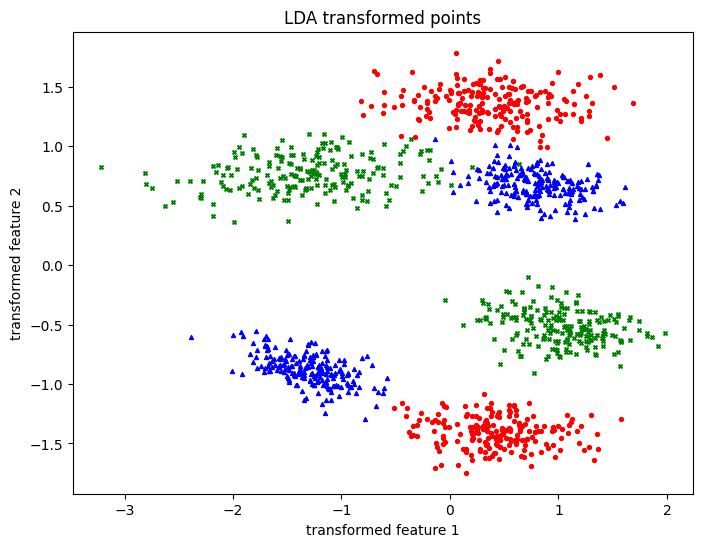

In [99]:
# plot
colors = ['r', 'g', 'b']
markers = ['o', 'x', '^']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train_lda[y_train == label, 0], X_train_lda[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)

plt.xlabel('transformed feature 1')
plt.ylabel('transformed feature 2')
plt.title('LDA transformed points')
plt.show()

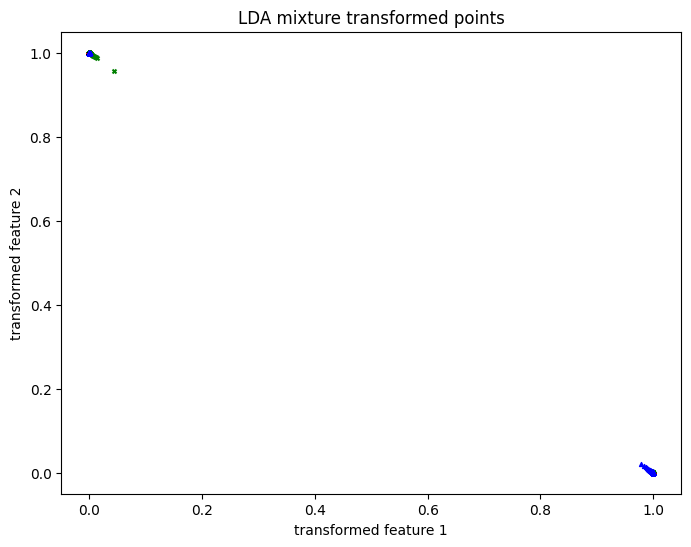

In [100]:
# plot
colors = ['r', 'g', 'b']
markers = ['o', 'x', '^']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train_lda_mixture[y_train == label, 0], X_train_lda_mixture[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)

plt.xlabel('transformed feature 1')
plt.ylabel('transformed feature 2')
plt.title('LDA mixture transformed points')
plt.show()

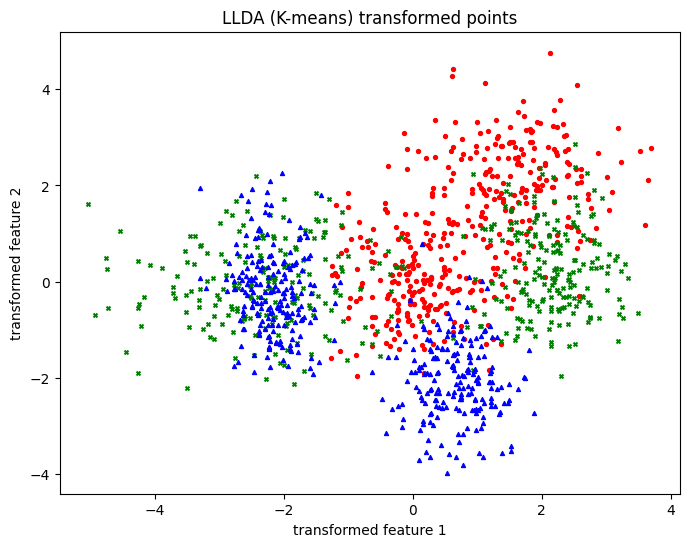

In [101]:
# plot
colors = ['r', 'g', 'b']
markers = ['o', 'x', '^']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train_llda_kmeans[y_train == label, 0], X_train_llda_kmeans[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)

plt.xlabel('transformed feature 1')
plt.ylabel('transformed feature 2')
plt.title('LLDA (K-means) transformed points')
plt.show()

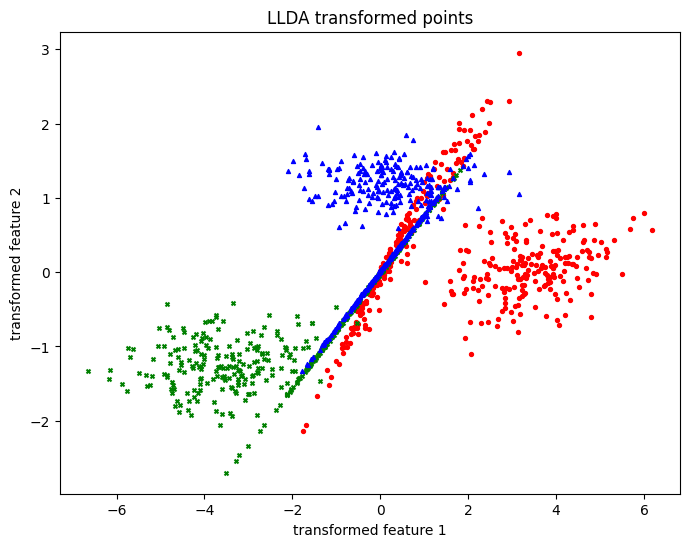

In [102]:
# plot
colors = ['r', 'g', 'b']
markers = ['o', 'x', '^']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train_llda[y_train == label, 0], X_train_llda[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)

plt.xlabel('transformed feature 1')
plt.ylabel('transformed feature 2')
plt.title('LLDA transformed points')
plt.show()

In [ ]:
# Generate Simulation Data (Set 2)
def generate_set2():
    """
    Generate the data from set 2, which contains two classes and each class has three modes.

    Args:
        None
    
    Returns:
        X (ndarray) : N-dimensional input features
        y (ndarray) : input classes
    """
    mean1_1 = [4.4, 5.4]
    cov1_1 = [[1, 0], [0, 0.5]]
    mean1_2 = [-4.7, -3.9]
    cov1_2 = [[1, 0], [0, 0.2]]
    mean1_3 = [4.4, -7.8]
    cov1_3 = [[1, 0], [0, 0.8]]
    mean2_1 = [7.6, 2.1]
    cov2_1 = [[1, 0], [0, 0.9]]
    mean2_2 = [-5, -0.9]
    cov2_2 = [[1, 0], [0, 0.6]]
    mean2_3 = [1.6, -9.9]
    cov2_3 = [[1, 0], [0, 0.7]]

    num_samples = 200
    class1 = np.vstack([np.random.multivariate_normal(mean1_1, cov1_1, num_samples),
                        np.random.multivariate_normal(mean1_2, cov1_2, num_samples),
                        np.random.multivariate_normal(mean1_3, cov1_3, num_samples)])
    class2 = np.vstack([np.random.multivariate_normal(mean2_1, cov2_1, num_samples),
                        np.random.multivariate_normal(mean2_2, cov2_2, num_samples),
                        np.random.multivariate_normal(mean2_3, cov2_3, num_samples)])

    X = np.vstack([class1, class2])
    y = np.concatenate([np.zeros(3 * num_samples), np.ones(3 * num_samples)])
    return X, y

In [ ]:
results_llda_list = []
result_llda_kmeans_list = []
results_lda_list = []
results_lda_mixture_list = []
results_llda_list_2 = []
result_llda_kmeans_list_2 = []
results_lda_list_2 = []
results_lda_mixture_list_2 = []
results_llda_list_3 = []
result_llda_kmeans_list_3 = []
results_lda_list_3 = []
results_lda_mixture_list_3 = []
for i in range(50):
    X, y = generate_set2()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    # Training LLDA_GMM model
    llda = LLDA_GMM(n_components=3, trans_dim =2, alpha=1, max_iter=50)
    llda.fit(X_train, y_train)
    X_train_llda = llda.transform(X_train)
    X_test_llda = llda.transform(X_test)

    # Training the LLDA_kmeans model
    llda_kmeans = LLDA_KMeans(n_clusters=3, d_components=2)
    llda_kmeans.fit(X_train, y_train)
    X_train_llda_kmeans = llda_kmeans.transform(X_train)
    X_test_llda_kmeans = llda_kmeans.transform(X_test)

    # Training the LDA model
    lda = LinearDiscriminantAnalysis()
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_test_lda = lda.transform(X_test)

    # Training the LDA mixture model
    lda_mixture = GaussianMixture(n_components=3)
    lda_mixture.fit(X_train)
    X_train_lda_mixture = lda_mixture.predict_proba(X_train)[:, :2]
    X_test_lda_mixture = lda_mixture.predict_proba(X_test)[:, :2]
    means = lda_mixture.means_
    weights = lda_mixture.weights_
    covariances = lda_mixture.covariances_
    eigenvectors_list = []
    eigenvalues_list = []
    for i, cov in enumerate(covariances):
        eigenvalues, eigenvectors = np.linalg.eigh(cov)
        eigenvectors_list.append(eigenvectors)
        eigenvalues_list.append(eigenvalues)
        print(f"The eigenvectors of {i + 1}-th Gaussian mixture:")
        print(eigenvectors)

    results_llda = evaluate_model_Euclidean(X_train_llda, y_train, X_test_llda, y_test)
    results_llda_list.append(results_llda['method']['mean_error'])

    results_llda_kmeans = evaluate_model_Euclidean(X_train_llda_kmeans, y_train, X_test_llda_kmeans, y_test)
    result_llda_kmeans_list.append(results_llda_kmeans['method']['mean_error'])

    results_lda = evaluate_model_Euclidean(X_train_lda,y_train, X_test_lda, y_test)
    results_lda_list.append(results_lda['method']['mean_error'])

    results_lda_mixture = evaluate_model_Euclidean(X_train_lda_mixture, y_train, X_test_lda_mixture, y_test)
    results_lda_mixture_list.append(results_lda_mixture['method']['mean_error'])

    results_llda = evaluate_model_normalized_correlation(X_train_llda, y_train, X_test_llda, y_test)
    results_llda_list_2.append(results_llda['method']['mean_error'])

    results_llda_kmeans = evaluate_model_normalized_correlation(X_train_llda_kmeans, y_train, X_test_llda_kmeans, y_test)
    result_llda_kmeans_list_2.append(results_llda_kmeans['method']['mean_error'])

    results_lda = evaluate_model_normalized_correlation(X_train_lda,y_train, X_test_lda, y_test)
    results_lda_list_2.append(results_lda['method']['mean_error'])

    results_lda_mixture = evaluate_model_normalized_correlation(X_train_lda_mixture, y_train, X_test_lda_mixture, y_test)
    results_lda_mixture_list_2.append(results_lda_mixture['method']['mean_error'])

    results_llda = evaluate_model_mahalanobis(X_train_llda, y_train, X_test_llda, y_test)
    results_llda_list_3.append(results_llda['method']['mean_error'])

    results_llda_kmeans = evaluate_model_mahalanobis(X_train_llda_kmeans, y_train, X_test_llda_kmeans, y_test)
    result_llda_kmeans_list_3.append(results_llda_kmeans['method']['mean_error'])

    #results_lda = evaluate_model_mahalanobis(X_train_lda,y_train, X_test_lda, y_test)
    results_lda_list_3.append(results_lda['method']['mean_error'])

    results_lda_mixture = evaluate_model_mahalanobis(X_train_lda_mixture, y_train, X_test_lda_mixture, y_test)
    results_lda_mixture_list_3.append(results_lda_mixture['method']['mean_error'])

# 1
print("\n Using Euclidean distance:")

average_misclassification = np.mean(np.array(results_llda_list))
std_misclassification = np.std(np.array(results_llda_list))

print("\nThe result for llda_GMM:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(result_llda_kmeans_list))
std_misclassification = np.std(np.array(result_llda_kmeans_list))

print("\nThe result for llda_Kmeans:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_list))
std_misclassification = np.std(np.array(results_lda_list))

print("\nThe result for lda:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_mixture_list))
std_misclassification = np.std(np.array(results_lda_mixture_list))

print("\nThe result for lda mixture:")
print("The average number of misclassification is:", average_misclassification)

# 2
print("\n Using normalized correlation:")

average_misclassification = np.mean(np.array(results_llda_list_2))
std_misclassification = np.std(np.array(results_llda_list_2))

print("\nThe result for llda_GMM:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(result_llda_kmeans_list_2))
std_misclassification = np.std(np.array(result_llda_kmeans_list_2))

print("\nThe result for llda_Kmeans:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_list_2))
std_misclassification = np.std(np.array(results_lda_list_2))

print("\nThe result for lda:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_mixture_list_2))
std_misclassification = np.std(np.array(results_lda_mixture_list_2))

print("\nThe result for lda mixture:")
print("The average number of misclassification is:", average_misclassification)

# 3
print("\n Using Mahalanobis distance:")

average_misclassification = np.mean(np.array(results_llda_list_3))
std_misclassification = np.std(np.array(results_llda_list_3))

print("\nThe result for llda_GMM:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(result_llda_kmeans_list_3))
std_misclassification = np.std(np.array(result_llda_kmeans_list_3))

print("\nThe result for llda_Kmeans:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_list_3))
std_misclassification = np.std(np.array(results_lda_list_3))

print("\nThe result for lda:")
print("The average number of misclassification is:", average_misclassification)

average_misclassification = np.mean(np.array(results_lda_mixture_list_3))
std_misclassification = np.std(np.array(results_lda_mixture_list_3))

print("\nThe result for lda mixture:")
print("The average number of misclassification is:", average_misclassification)

[array([[-0.68501172, -0.68306222],
       [ 0.72853204,  0.73036018]]), array([[-0.77417518,  0.83768198],
       [-0.6329714 ,  0.5461583 ]]), array([[ 0.64011618,  0.18718767],
       [-0.76827812, -0.98232417]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.72891257 -0.6846068 ]
 [-0.6846068   0.72891257]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.98942985 -0.14501229]
 [-0.14501229  0.98942985]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.58188108 -0.81327388]
 [-0.81327388 -0.58188108]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.69138306, -0.69105085],
       [ 0.72248838,  0.72280615]]), array([[-0.72664881, -0.73129388],
       [-0.68700911, -0.68206251]]), array([[ 0.62687562,  0.62452752],
       [-0.77911935, -0.7810028 ]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.97549595 -0.2200174 ]
 [-0.2200174   0.97549595]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.71690933 -0.69716642]
 [-0.69716642  0.71690933]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.58557772 -0.81061627]
 [-0.81061627 -0.58557772]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.09243982, -0.091958  ],
       [-0.99571827,  0.99576289]]), array([[-0.63064697,  0.64990966],
       [ 0.77606984, -0.76001147]]), array([[-0.90178677, -0.74970288],
       [-0.43218125, -0.66177457]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.56012955 -0.82840503]
 [-0.82840503 -0.56012955]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.66950284 -0.7428095 ]
 [-0.7428095   0.66950284]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.99550522 -0.09470672]
 [-0.09470672  0.99550522]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.71332207,  0.71902703],
       [ 0.70083638, -0.69498211]]), array([[0.8550535 , 0.71144005],
       [0.51853979, 0.70274679]]), array([[ 0.19422165, -0.71349427],
       [-0.98095767,  0.70066107]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.99428266 -0.10678011]
 [-0.10678011  0.99428266]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.57474612 -0.81833178]
 [-0.81833178 -0.57474612]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.68456272 -0.72895396]
 [-0.72895396  0.68456272]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.84192006,  0.84517568],
       [-0.53960227,  0.53448861]]), array([[ 0.71313776,  0.63429245],
       [-0.70102392, -0.7730932 ]]), array([[-0.14784423, -0.5602599 ],
       [ 0.98901066,  0.82831688]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.72100234 -0.69293263]
 [-0.69293263  0.72100234]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.98921958 -0.14643984]
 [-0.14643984  0.98921958]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.5288696 -0.8487031]
 [-0.8487031 -0.5288696]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.70774154, -0.70593699],
       [ 0.70647145,  0.70827464]]), array([[-0.79242135,  0.90245385],
       [-0.60997411,  0.43078655]]), array([[ 0.62148334,  0.22368591],
       [-0.78342738, -0.97466128]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.52754277 -0.84952847]
 [-0.84952847 -0.52754277]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.70388732 -0.71031165]
 [-0.71031165  0.70388732]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.99073133 -0.13583602]
 [-0.13583602  0.99073133]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.82991685, -0.82986211],
       [-0.5578871 , -0.55796852]]), array([[ 0.737569  ,  0.73571337],
       [-0.67527178, -0.67729302]]), array([[-0.19007884, -0.19049791],
       [ 0.98176883,  0.9816876 ]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.9901754  -0.13983091]
 [-0.13983091  0.9901754 ]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.55157824 -0.83412316]
 [-0.83412316 -0.55157824]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.70479549 -0.70941054]
 [-0.70941054  0.70479549]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.75511862, -0.7685407 ],
       [ 0.65558818, -0.6398009 ]]), array([[-0.705076  ,  0.72457657],
       [ 0.70913175, -0.6891943 ]]), array([[ 0.08417712, -0.08330876],
       [-0.99645081,  0.99652378]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.70687036 -0.70734313]
 [-0.70734313  0.70687036]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.99939163 -0.03487653]
 [-0.03487653  0.99939163]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.61888265 -0.78548346]
 [-0.78548346 -0.61888265]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[0.79535846, 0.79446925],
       [0.60613935, 0.60730438]]), array([[-0.69130781, -0.69011725],
       [ 0.72256039,  0.72369757]]), array([[ 0.18170266,  0.18152878],
       [-0.98335352, -0.98338563]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.73159558 -0.68173888]
 [-0.68173888  0.73159558]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.5731704  -0.81943621]
 [-0.81943621 -0.5731704 ]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.98581791 -0.16781848]
 [-0.16781848  0.98581791]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.81312689,  0.8120982 ],
       [-0.58208648,  0.58352079]]), array([[ 0.7482601 , -0.74995347],
       [-0.66340547,  0.66149059]]), array([[-0.03793793,  0.03681756],
       [ 0.9992801 , -0.999322  ]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.99911098 -0.04215733]
 [-0.04215733  0.99911098]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.68853497 -0.72520314]
 [-0.72520314  0.68853497]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.57115256 -0.82084393]
 [-0.82084393 -0.57115256]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.16486508,  0.15326162],
       [ 0.98631613, -0.98818565]]), array([[-0.65089697,  0.69061144],
       [-0.75916608,  0.72322599]]), array([[-0.85568889, -0.60141546],
       [ 0.5174906 ,  0.79893645]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.59100026 -0.80667137]
 [-0.80667137 -0.59100026]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.70067494 -0.71348064]
 [-0.71348064  0.70067494]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.97402089 -0.22645817]
 [-0.22645817  0.97402089]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.79676561,  0.79369146],
       [-0.60428848,  0.60832053]]), array([[-0.65125244, -0.69899388],
       [ 0.75886116,  0.71512765]]), array([[ 0.56613804,  0.03259922],
       [-0.82431045,  0.9994685 ]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.98599738 -0.16676078]
 [-0.16676078  0.98599738]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.73613104 -0.67683904]
 [-0.67683904  0.73613104]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.59607707 -0.80292722]
 [-0.80292722 -0.59607707]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[0.80201522, 0.80041187],
       [0.5973036 , 0.59945044]]), array([[-0.7253972 , -0.71123594],
       [ 0.68833051,  0.70295336]]), array([[-0.00524097,  0.16889848],
       [ 0.99998627, -0.98563345]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.71989091 -0.69408723]
 [-0.69408723  0.71989091]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.98424193 -0.17682708]
 [-0.17682708  0.98424193]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.5846549 -0.8112821]
 [-0.8112821 -0.5846549]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.12546824,  0.12693053],
       [-0.99209764, -0.99191161]]), array([[0.729641  , 0.75509799],
       [0.6838304 , 0.65561195]]), array([[ 0.82902322, -0.64521931],
       [-0.55921418,  0.76399741]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.98955071 -0.14418528]
 [-0.14418528  0.98955071]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.50099289 -0.8654514 ]
 [-0.8654514  -0.50099289]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.6833473  -0.73009347]
 [-0.73009347  0.6833473 ]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.15604996, -0.14719851],
       [-0.98774916,  0.98910697]]), array([[-0.63703648,  0.63645824],
       [ 0.77083365, -0.77131116]]), array([[ 0.68362558, -0.68148952],
       [ 0.7298329 , -0.73182787]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.68509093 -0.72845756]
 [-0.72845756  0.68509093]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.59440283 -0.80416744]
 [-0.80416744 -0.59440283]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.98277144 -0.18482505]
 [-0.18482505  0.98277144]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.82721963, -0.81454647],
       [-0.56187871, -0.58009831]]), array([[-0.67207734,  0.77218439],
       [ 0.74048096, -0.63539851]]), array([[ 0.58578756, -0.11275728],
       [-0.81046464,  0.99362256]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.99628825 -0.08607978]
 [-0.08607978  0.99628825]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.56434832 -0.82553678]
 [-0.82553678 -0.56434832]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.6887752  -0.72497499]
 [-0.72497499  0.6887752 ]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.14342832,  0.14295266],
       [-0.98966071, -0.98972953]]), array([[-0.6424423 , -0.6387034 ],
       [ 0.76633406,  0.76945303]]), array([[0.66117467, 0.65903983],
       [0.75023201, 0.75210804]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.6868426  -0.72680619]
 [-0.72680619  0.6868426 ]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.98725959 -0.15911789]
 [-0.15911789  0.98725959]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.61675531 -0.78715493]
 [-0.78715493 -0.61675531]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.68979766,  0.69912523],
       [ 0.7240022 , -0.71499924]]), array([[ 0.56501697, -0.25508543],
       [-0.82507928, -0.96691852]]), array([[-0.79089829,  0.56505454],
       [-0.61194762,  0.82505355]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.53845101 -0.84265681]
 [-0.84265681 -0.53845101]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.71798965 -0.69605377]
 [-0.69605377  0.71798965]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.96580931 -0.2592535 ]
 [-0.2592535   0.96580931]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.72892585, -0.72683672],
       [ 0.68459266,  0.68681029]]), array([[-0.77811483, -0.69235003],
       [-0.62812205, -0.7215618 ]]), array([[ 0.64192937,  0.6967878 ],
       [-0.76676377, -0.71727732]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.99469362 -0.10288151]
 [-0.10288151  0.99469362]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.6754378  -0.73741697]
 [-0.73741697  0.6754378 ]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.5060298 -0.862516 ]
 [-0.862516  -0.5060298]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.81377064, -0.81681413],
       [ 0.58118615, -0.57690092]]), array([[-0.69991052, -0.64294558],
       [ 0.71423054,  0.76591187]]), array([[ 0.16340393,  0.5807317 ],
       [-0.98655925, -0.81409501]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.57837831 -0.81576867]
 [-0.81576867 -0.57837831]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.73383876 -0.67932369]
 [-0.67932369  0.73383876]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.9876452  -0.15670661]
 [-0.15670661  0.9876452 ]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.01160326,  0.01150337],
       [-0.99993268, -0.99993383]]), array([[-0.60608446, -0.62298739],
       [ 0.79540029,  0.78223188]]), array([[0.69641607, 0.70468368],
       [0.71763825, 0.70952161]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.99991409 -0.01310781]
 [-0.01310781  0.99991409]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.58527849 -0.81083235]
 [-0.81083235 -0.58527849]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.69646781 -0.71758803]
 [-0.71758803  0.69646781]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.74389324, -0.73006889],
       [-0.66829847,  0.68337355]]), array([[0.73471287, 0.92542131],
       [0.67837821, 0.37893984]]), array([[-0.61636678,  0.25812155],
       [ 0.7874592 , -0.96611245]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.98825795 -0.15279469]
 [-0.15279469  0.98825795]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.65705191 -0.75384534]
 [-0.75384534  0.65705191]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.5307953  -0.84750006]
 [-0.84750006 -0.5307953 ]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.69225479, -0.69244339],
       [ 0.72165317,  0.72147221]]), array([[0.8558385 , 0.89352544],
       [0.51724314, 0.44901257]]), array([[ 0.23487371,  0.26199041],
       [-0.9720259 , -0.96507048]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.98452632 -0.17523678]
 [-0.17523678  0.98452632]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.55795699 -0.82986987]
 [-0.82986987 -0.55795699]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.72107314 -0.69285895]
 [-0.69285895  0.72107314]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.7168186 , -0.70584989],
       [ 0.6972597 ,  0.70836144]]), array([[-0.75782857,  0.84496848],
       [-0.65245372,  0.53481611]]), array([[ 0.62635633,  0.23247312],
       [-0.77953688, -0.97260282]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.7005396  -0.71361353]
 [-0.71361353  0.7005396 ]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.57011045 -0.82156806]
 [-0.82156806 -0.57011045]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.98710631 -0.16006606]
 [-0.16006606  0.98710631]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.68587067,  0.69140252],
       [-0.72772345, -0.72246977]]), array([[-0.42679844, -0.11613033],
       [ 0.90434678, -0.99323398]]), array([[0.81136599, 0.6020728 ],
       [0.58453848, 0.7984412 ]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.96681301 -0.25548505]
 [-0.25548505  0.96681301]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.72026084 -0.69370334]
 [-0.69370334  0.72026084]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.52475288 -0.85125461]
 [-0.85125461 -0.52475288]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.6987968 ,  0.69476082],
       [ 0.71532024, -0.71924085]]), array([[-0.75756335, -0.84852135],
       [-0.65276165, -0.52916115]]), array([[ 0.64456843, -0.22758671],
       [-0.76454663,  0.97375782]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.98192013 -0.18929568]
 [-0.18929568  0.98192013]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.70716712 -0.70704644]
 [-0.70704644  0.70716712]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.53824583 -0.84278789]
 [-0.84278789 -0.53824583]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.05679949, -0.06060468],
       [-0.99838561,  0.99816185]]), array([[-0.6195169 ,  0.58789487],
       [ 0.78498332, -0.80893734]]), array([[0.75829274, 0.93081516],
       [0.65191419, 0.36549027]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.99710262 -0.07606817]
 [-0.07606817  0.99710262]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.69721462 -0.71686246]
 [-0.71686246  0.69721462]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.51977783 -0.85430148]
 [-0.85430148 -0.51977783]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.15938365,  0.15966833],
       [ 0.98721672, -0.98717072]]), array([[ 0.64658074, -0.63801959],
       [-0.76284556,  0.77002013]]), array([[-0.72587782,  0.72152607],
       [-0.68782366,  0.69238726]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.67092285 -0.74152716]
 [-0.74152716  0.67092285]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.98215689 -0.18806342]
 [-0.18806342  0.98215689]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.58345571 -0.81214496]
 [-0.81214496 -0.58345571]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.7137781 ,  0.7109634 ],
       [-0.70037192, -0.70322901]]), array([[-0.32319062, -0.37426633],
       [ 0.94633389,  0.92732126]]), array([[-0.85737904,  0.82631609],
       [-0.51468552,  0.56320664]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.50292187 -0.86433188]
 [-0.86433188 -0.50292187]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.69697763 -0.71709287]
 [-0.71709287  0.69697763]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.99346617 -0.11412703]
 [-0.11412703  0.99346617]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.05058149,  0.05608382],
       [ 0.99871994, -0.99842606]]), array([[ 0.58247319, -0.53809572],
       [-0.81284991,  0.84288374]]), array([[-0.62078439, -0.95198451],
       [-0.78398134, -0.30614619]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.99686312 -0.0791449 ]
 [-0.0791449   0.99686312]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.74208716 -0.6703034 ]
 [-0.6703034   0.74208716]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.60968621 -0.79264288]
 [-0.79264288 -0.60968621]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.72794045, -0.73883314],
       [ 0.68564036,  0.67388841]]), array([[ 0.22523575,  0.28568924],
       [-0.97430429,  0.95832231]]), array([[ 0.73871929, -0.53461367],
       [ 0.67401321, -0.84509657]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.99957003 -0.02932168]
 [-0.02932168  0.99957003]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.66958246 -0.74273773]
 [-0.74273773  0.66958246]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.57622524 -0.81729093]
 [-0.81729093 -0.57622524]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.18262796,  0.25138932],
       [ 0.98318209, -0.96788605]]), array([[ 0.61917644,  0.85095926],
       [-0.78525189, -0.52523169]]), array([[-0.72421078,  0.53666385],
       [-0.68957867,  0.84379613]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.97213564 -0.23441908]
 [-0.23441908  0.97213564]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.58141752 -0.81360535]
 [-0.81360535 -0.58141752]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.70350112 -0.71069415]
 [-0.71069415  0.70350112]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.70677713, -0.70466735],
       [-0.70743628,  0.70953782]]), array([[-0.35730894,  0.32388543],
       [ 0.93398625, -0.94609631]]), array([[-0.77326745,  0.76453551],
       [-0.63408001,  0.64458162]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.69899117 -0.71513029]
 [-0.71513029  0.69899117]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.97131796 -0.23778439]
 [-0.23778439  0.97131796]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.59123307 -0.80650075]
 [-0.80650075 -0.59123307]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.12134713,  0.1316424 ],
       [ 0.99261013, -0.99129727]]), array([[ 0.65102548, -0.59637881],
       [-0.75905588,  0.80270313]]), array([[-0.71169972, -0.9166178 ],
       [-0.70248381, -0.39976468]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.58106849 -0.81385466]
 [-0.81385466 -0.58106849]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.67013518 -0.74223907]
 [-0.74223907  0.67013518]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.98773348 -0.15614917]
 [-0.15614917  0.98773348]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.68389223, -0.69552651],
       [-0.72958304,  0.71850044]]), array([[-0.86879921, -0.78380121],
       [-0.49516455, -0.62101181]]), array([[-0.21017194,  0.61911366],
       [ 0.97766444, -0.78530139]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.55678233 -0.83065843]
 [-0.83065843 -0.55678233]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.71807991 -0.69596066]
 [-0.69596066  0.71807991]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.98729826 -0.15887778]
 [-0.15887778  0.98729826]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.73635632, -0.73286779],
       [ 0.67659395,  0.68037108]]), array([[-0.72127418,  0.89631157],
       [-0.69264966,  0.44342481]]), array([[ 0.64726857,  0.22735106],
       [-0.76226202, -0.97381286]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.67167813 -0.7408431 ]
 [-0.7408431   0.67167813]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.99172477 -0.1283822 ]
 [-0.1283822   0.99172477]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.59217868 -0.80580668]
 [-0.80580668 -0.59217868]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.03960512,  0.03941607],
       [ 0.99921541, -0.99922288]]), array([[ 0.63054302, -0.63199275],
       [-0.7761543 ,  0.7749743 ]]), array([[-0.76873716,  0.76932385],
       [-0.63956484,  0.638859  ]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.99876943 -0.04959464]
 [-0.04959464  0.99876943]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.53221506 -0.84660919]
 [-0.84660919 -0.53221506]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.69281464 -0.72111571]
 [-0.72111571  0.69281464]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.83920096, -0.83996865],
       [ 0.54382143, -0.54263493]]), array([[ 0.05068184, -0.05049343],
       [-0.99871485,  0.99872439]]), array([[-0.65799413,  0.65836542],
       [ 0.75302306, -0.75269846]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.97838693 -0.20678251]
 [-0.20678251  0.97838693]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.70699814 -0.7072154 ]
 [-0.7072154   0.70699814]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.52027871 -0.85399652]
 [-0.85399652 -0.52027871]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.79106791,  0.79142709],
       [-0.61172834,  0.61126357]]), array([[ 0.75608273, -0.75263414],
       [-0.65447605,  0.65843895]]), array([[-0.18065188,  0.18175139],
       [ 0.9835471 , -0.98334451]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.68827851 -0.72544655]
 [-0.72544655  0.68827851]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.98805197 -0.1541211 ]
 [-0.1541211   0.98805197]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.60234487 -0.79823596]
 [-0.79823596 -0.60234487]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.18554251,  0.23104323],
       [-0.98263624, -0.97294349]]), array([[-0.66193405,  0.83329095],
       [ 0.74956208, -0.55283469]]), array([[ 0.70336106, -0.97627112],
       [ 0.71083276, -0.21655184]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.57312221 -0.81946991]
 [-0.81946991 -0.57312221]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.97752672 -0.21081156]
 [-0.21081156  0.97752672]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.66061759 -0.75072258]
 [-0.75072258  0.66061759]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.72004594, -0.72026609],
       [-0.6939264 ,  0.69369789]]), array([[-0.88234726,  0.8897024 ],
       [-0.47059888,  0.45654095]]), array([[-0.21830811,  0.22427585],
       [ 0.9758799 , -0.9745257 ]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.98840616 -0.151833  ]
 [-0.151833    0.98840616]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.6828264  -0.73058066]
 [-0.73058066  0.6828264 ]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.54372299 -0.83926474]
 [-0.83926474 -0.54372299]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.08289029,  0.08224794],
       [-0.99655868, -0.9966119 ]]), array([[-0.61094525, -0.60164536],
       [ 0.79167285,  0.79876333]]), array([[0.70829924, 0.70344956],
       [0.70591231, 0.71074518]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.56927869 -0.82214462]
 [-0.82214462 -0.56927869]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.71979742 -0.69418418]
 [-0.69418418  0.71979742]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.98972607 -0.14297663]
 [-0.14297663  0.98972607]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.15846153, -0.15961094],
       [-0.98736515,  0.98718   ]]), array([[-0.63366961,  0.63421735],
       [ 0.77360379, -0.77315481]]), array([[ 0.71541931, -0.71588789],
       [ 0.69869536, -0.69821525]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.7006086  -0.71354579]
 [-0.71354579  0.7006086 ]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.58475293 -0.81121145]
 [-0.81121145 -0.58475293]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.97834842 -0.20696467]
 [-0.20696467  0.97834842]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.68390272,  0.68353606],
       [ 0.72957321, -0.72991674]]), array([[ 0.30141711, -0.28137655],
       [-0.95349238,  0.95959744]]), array([[ 0.69998831, -0.69574941],
       [ 0.7141543 , -0.7182846 ]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.5923756  -0.80566193]
 [-0.80566193 -0.5923756 ]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.72774923 -0.68584332]
 [-0.68584332  0.72774923]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.99398531 -0.10951348]
 [-0.10951348  0.99398531]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.07987873,  0.08080162],
       [ 0.99680459, -0.9967302 ]]), array([[ 0.57112959, -0.57545691],
       [-0.82085991,  0.8178321 ]]), array([[ 0.94671197, -0.94528883],
       [ 0.32208142, -0.32623461]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.70685859 -0.70735489]
 [-0.70735489  0.70685859]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.99641837 -0.08456017]
 [-0.08456017  0.99641837]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.54559452 -0.83804929]
 [-0.83804929 -0.54559452]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.803355  , -0.78780314],
       [-0.59550042, -0.61592712]]), array([[ 0.29278361,  0.22668984],
       [-0.95617873,  0.973967  ]]), array([[-0.56287254, -0.75623583],
       [ 0.82654371,  0.65429915]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.70549724 -0.70871267]
 [-0.70871267  0.70549724]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.99136094 -0.13116206]
 [-0.13116206  0.99136094]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.59374422 -0.80465384]
 [-0.80465384 -0.59374422]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[ 0.67371976,  0.65513817],
       [-0.73898693, -0.75550908]]), array([[-0.19683285, -0.37326514],
       [-0.98043706,  0.92772471]]), array([[ 0.56338105, -0.67015259],
       [ 0.82619719, -0.74222336]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.96346395 -0.26783803]
 [-0.26783803  0.96346395]]
The eigenvectors of 2-th Gaussian mixture:
[[ 0.6259483  -0.77986455]
 [-0.77986455 -0.6259483 ]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.74401675 -0.66816097]
 [-0.66816097  0.74401675]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.71213361,  0.7396776 ],
       [ 0.70204396, -0.6729614 ]]), array([[ 0.36612524, -0.24128778],
       [-0.93056558, -0.97045361]]), array([[-0.81853634,  0.56844959],
       [-0.57445475,  0.82271809]])]
The eigenvectors of 1-th Gaussian mixture:
[[ 0.51096256 -0.85960297]
 [-0.85960297 -0.51096256]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.68641484 -0.7272102 ]
 [-0.7272102   0.68641484]]
The eigenvectors of 3-th Gaussian mixture:
[[-0.99791942 -0.06447347]
 [-0.06447347  0.99791942]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.85053482, -0.85175501],
       [-0.52591874, -0.52394027]]), array([[ 0.74151971,  0.74374162],
       [-0.67093108, -0.66846721]]), array([[-0.0769756 , -0.12330319],
       [ 0.99703298, -0.99236905]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.99908738 -0.04271302]
 [-0.04271302  0.99908738]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.71967013 -0.69431614]
 [-0.69431614  0.71967013]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.4966939  -0.86792579]
 [-0.86792579 -0.4966939 ]]


/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


[array([[-0.72657675, -0.74267783],
       [ 0.68708531,  0.66964889]]), array([[ 0.470106  ,  0.27180584],
       [-0.88260996,  0.96235211]]), array([[-0.78723409, -0.54424121],
       [-0.61665427, -0.83892878]])]
The eigenvectors of 1-th Gaussian mixture:
[[-0.98297255 -0.18375243]
 [-0.18375243  0.98297255]]
The eigenvectors of 2-th Gaussian mixture:
[[-0.66704126 -0.74502078]
 [-0.74502078  0.66704126]]
The eigenvectors of 3-th Gaussian mixture:
[[ 0.53656748 -0.84385742]
 [-0.84385742 -0.53656748]]

 Using Euclidean distance:

The result for llda_GMM:
The average number of misclassification is: 71.01

The result for llda_Kmeans:
The average number of misclassification is: 85.07

The result for lda:
The average number of misclassification is: 199.73

The result for lda mixture:
The average number of misclassification is: 158.0

 Using normalized correlation:

The result for llda_GMM:
The average number of misclassification is: 93.91

The result for llda_Kmeans:
The average number

/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bytedance/Desktop/vscode_python/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


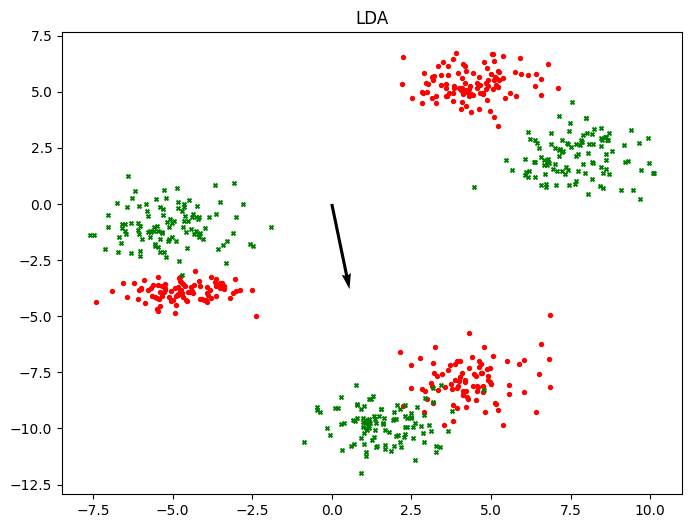

In [ ]:
# Perform LDA
# plot the result
colors = ['r', 'g']
markers = ['o', 'x']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train[y_train == label, 0], X_train[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)
# obtain the eigenvectors
eigenvectors = lda.scalings_
# plot the first component
origin_x = 0  
origin_y = 0  
origin = np.array([[origin_x, origin_y]]) 
first_component = eigenvectors[:, 0].reshape(1, -1)
plt.quiver(*origin[:, 0], *origin[:, 1], *first_component[:, 0], *first_component[:, 1], 
           angles='xy', scale_units='xy', scale=0.05, color='black', width=0.005,  label='First Major Component')
# plot the second component
#second_component = -eigenvectors[:, 1].reshape(1, -1)
#plt.quiver(*origin[:, 0], *origin[:, 1], *second_component[:, 0], *second_component[:, 1],  
#           angles='xy', scale_units='xy', scale=0.035, color='gray', width=0.005,  linestyle='--',  linewidth=2, label='Second Component')
plt.title("LDA")
# plt.legend()
plt.show()

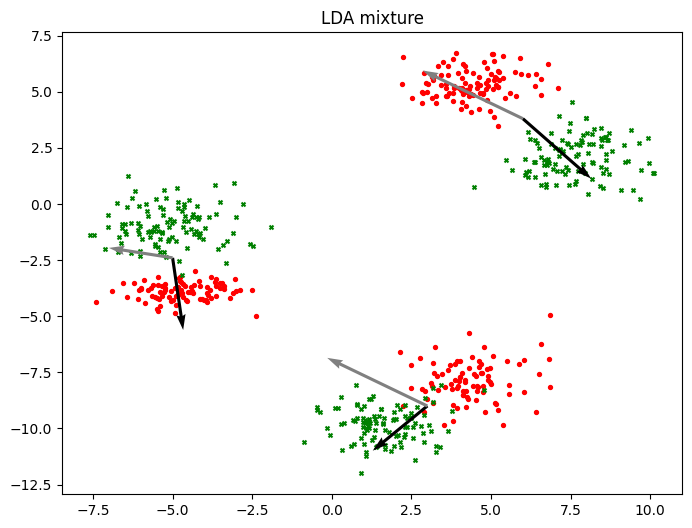

In [72]:
# plot
colors = ['r', 'g']
markers = ['o', 'x']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train[y_train == label, 0], X_train[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)

from sklearn.linear_model import LinearRegression
# plot the first component
origin_x = -5
origin_y = -2.4
origin = np.array([[origin_x, origin_y]]) 
first_component = -covariances[0][:, 1].reshape(1,-1)
plt.quiver(*origin[:, 0], *origin[:, 1], *first_component[:, 0], *first_component[:, 1], 
           angles='xy', scale_units='xy', scale=0.8, color='black', width=0.005,  label='First Major Component')
# plot the second component
second_component = -covariances[0][:, 0].reshape(1,-1)
plt.quiver(*origin[:, 0], *origin[:, 1], *second_component[:, 0], *second_component[:, 1],  
           angles='xy', scale_units='xy', scale=0.6, color='gray', width=0.005,  linestyle='--',  linewidth=2, label='Second Component')
# plot the first component
origin_x = 6
origin_y = 3.8
origin = np.array([[origin_x, origin_y]]) 
first_component = -covariances[1][:, 1].reshape(1,-1)
plt.quiver(*origin[:, 0], *origin[:, 1], *first_component[:, 0], *first_component[:, 1], 
           angles='xy', scale_units='xy', scale=1.2, color='black', width=0.005,  label='First Major Component')
# plot the second component
second_component = -covariances[1][:, 0].reshape(1,-1)
plt.quiver(*origin[:, 0], *origin[:, 1], *second_component[:, 0], *second_component[:, 1],  
           angles='xy', scale_units='xy', scale=1.2, color='gray', width=0.005,  linestyle='--',  linewidth=2, label='Second Component')
# plot the first component
origin_x = 3
origin_y = -9
origin = np.array([[origin_x, origin_y]]) 
first_component = -covariances[2][:, 1].reshape(1,-1)
plt.quiver(*origin[:, 0], *origin[:, 1], *first_component[:, 0], *first_component[:, 1], 
           angles='xy', scale_units='xy', scale=0.8, color='black', width=0.005,  label='First Major Component')
# plot the second component
second_component = -covariances[1][:, 0].reshape(1,-1)
plt.quiver(*origin[:, 0], *origin[:, 1], *second_component[:, 0], *second_component[:, 1],  
           angles='xy', scale_units='xy', scale=1.2, color='gray', width=0.005,  linestyle='--',  linewidth=2, label='Second Component')
plt.title("LDA mixture")
# plt.legend()
plt.show()

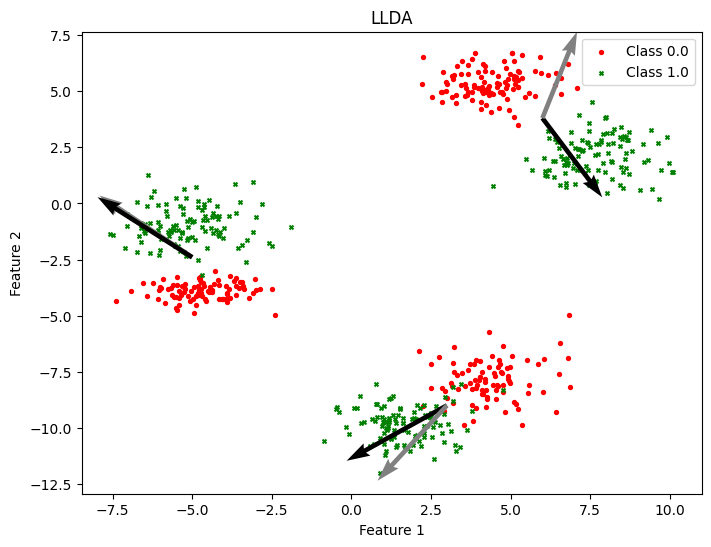

In [74]:
# plot
colors = ['r', 'g']
markers = ['o', 'x']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train[y_train == label, 0], X_train[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)

# 绘制向量(1, 1)，起点为(0, 0)
plt.quiver(-5, -2.4, -0.72657675, 0.68708531, angles='xy', scale_units='xy', scale=0.25, linestyle='--',color='grey')
plt.quiver(-5, -2.4, -0.74267783, 0.66964889, angles='xy', scale_units='xy', scale=0.25, color='black')
plt.quiver(6, 3.8, 0.470106, -0.88260996, angles='xy', scale_units='xy', scale=0.25, color='black')
plt.quiver(6, 3.8, 0.27180584, 0.96235211, angles='xy', scale_units='xy', scale=0.25,linestyle='--', color='grey')
plt.quiver(3, -9, -0.78723409,  -0.61665427, angles='xy', scale_units='xy', scale=0.25, color='black')
plt.quiver(3, -9, -0.54424121, -0.83892878, angles='xy', scale_units='xy', scale=0.25,linestyle='--', color='grey')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('LLDA')
plt.legend()
plt.show()

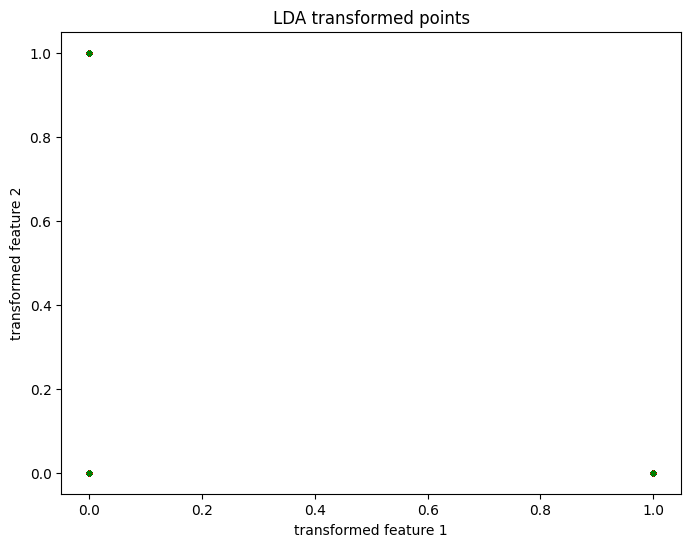

In [94]:
# plot
colors = ['r', 'g']
markers = ['o', 'x']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train_lda_mixture[y_train == label, 0], X_train_lda_mixture[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)

plt.xlabel('transformed feature 1')
plt.ylabel('transformed feature 2')
plt.title('LDA transformed points')
plt.show()

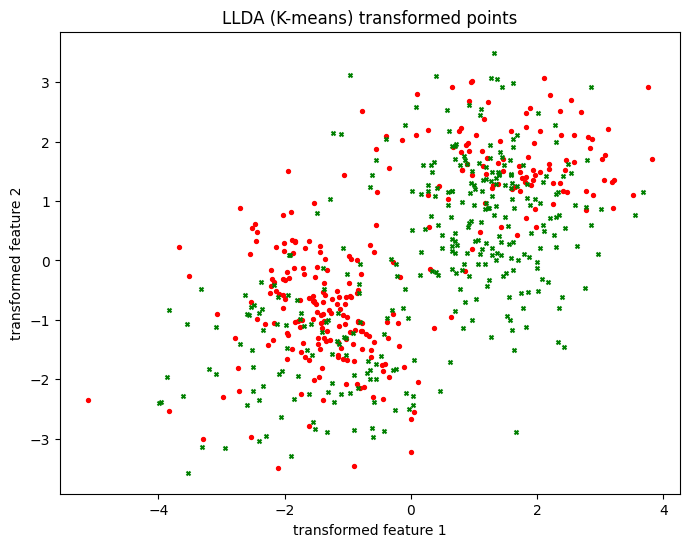

In [77]:
# plot
colors = ['r', 'g']
markers = ['o', 'x']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train_llda_kmeans[y_train == label, 0], X_train_llda_kmeans[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)

plt.xlabel('transformed feature 1')
plt.ylabel('transformed feature 2')
plt.title('LLDA (K-means) transformed points')
plt.show()

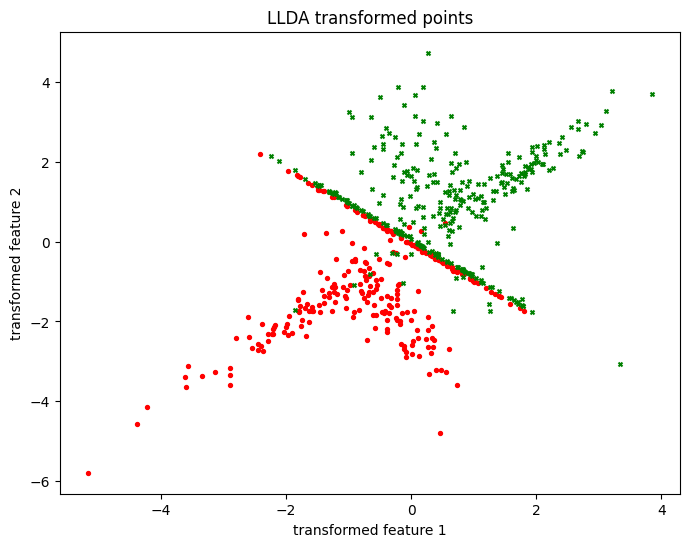

In [76]:
# plot
colors = ['r', 'g']
markers = ['o', 'x']
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(y_train)):
    plt.scatter(X_train_llda[y_train == label, 0], X_train_llda[y_train == label, 1], 
                c=colors[i], marker=markers[i], label=f'Class {label}', s=8)

plt.xlabel('transformed feature 1')
plt.ylabel('transformed feature 2')
plt.title('LLDA transformed points')
plt.show()